General sources:

- https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
- https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from google.colab import drive
import pickle

drive.mount('/content/drive/')

def load_pickle(path):
    with open(path, 'rb') as f:
        file = pickle.load(f)
        print ('Loaded %s..' %path)
        return file

dataset_directory = '/content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset'

emotions = ['anger', 'fear', 'joy', 'sadness']

tweets_train = np.load(join(dataset_directory, 'text_train_tweets.npy'))
labels_train = np.load(join(dataset_directory, 'text_train_labels.npy'))
vocabulary = load_pickle(join(dataset_directory, 'text_word_to_idx.pkl'))

tweets_val = np.load(join(dataset_directory, 'text_val_tweets.npy'))
labels_val = np.load(join(dataset_directory, 'text_val_labels.npy'))

tweets_test_public = np.load(join(dataset_directory, 'text_test_public_tweets_rand.npy'))

print(len(vocabulary))
idx_to_word = {i: w for w, i in vocabulary.items()}
for i in range(7):
  print(i, idx_to_word[i])

sample = 1

print('sample tweet, stored form:')
print(tweets_train[sample])
print(labels_train[sample])

print('sample tweet, readable form:')
decode = []
#tweet_string
for i in range(50):
  decode.append(idx_to_word[tweets_train[sample][i]])
print(decode)
print(emotions[labels_train[sample]])

print("\nPossible words for each feature:", len(vocabulary))
print("Training data X:", tweets_train.shape)
print("Training data y:", labels_train.shape)
print("Val data X:", tweets_val.shape)
print("Val data y:", labels_val.shape)
print("Test data X:", tweets_test_public.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Loaded /content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset/text_word_to_idx.pkl..
13978
0 <NULL>
1 <START>
2 <END>
3 it
4 makes
5 me
6 so
sample tweet, stored form:
[ 1 23 24 20 25 19 26 27 28  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
0
sample tweet, readable form:
['<START>', 'lol', 'adam', 'the', 'bull', 'with', 'his', 'fake', 'outrage', '<

In [0]:
# create a test submission file with all tweets predicted as 'anger' (1)
y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), np.ones(4064).astype(int)]
y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)

## Data Exploration

How many times does each emotion appear in the training set? Are the classes well balanced?


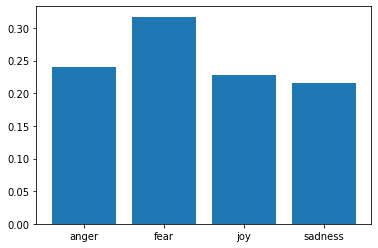

In [0]:
emotion_nums, counts = np.unique(labels_train, return_counts=True)
plt.bar(emotions, counts/len(labels_train));

# Answer: the classes are reasonably well balanced

Are the tweets for different emotions of similar length on average?

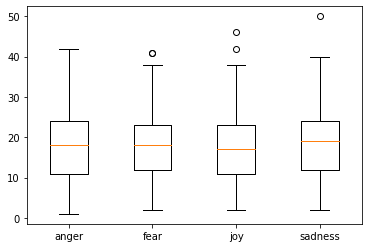

In [0]:
# Count number of words per tweet. The tweets include items that are not words like <START>, <END> and <NULL>. Don't
# include these in the count.
tweets_train_wordcount = []
for tweet in tweets_train:
  word_count = 0
  for vocab_idx in tweet:
    word = idx_to_word[vocab_idx]
    if word not in ['<START>', '<END>', '<NULL>']:
      word_count += 1
  tweets_train_wordcount.append(word_count)
tweets_train_wordcount = np.array(tweets_train_wordcount)

# box-plots
anger = tweets_train_wordcount[np.array(labels_train==0)]
fear = tweets_train_wordcount[np.array(labels_train==1)]
joy = tweets_train_wordcount[np.array(labels_train==2)]
sadness = tweets_train_wordcount[np.array(labels_train==3)]

plt.boxplot([anger, fear, joy, sadness]);
plt.xticks([1, 2, 3, 4], emotions);

# Answer: yes, tweet lenghts appear to be similar across different emotions

## Data pre-processing:

De-emoji, remove hashtags, stop words, punctuation and lemmatize the tweets:

In [0]:
# Some of this code comes from the lecture notes

!pip install emoji --upgrade
import emoji

import string
from collections import defaultdict

import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet as wn

tag_map = defaultdict(lambda : wn.NOUN); tag_map['J'] = wn.ADJ; tag_map['V'] = wn.VERB; tag_map['R'] = wn.ADV

def normalise_tweets(tweets):
  lemmatizer = WordNetLemmatizer()
  stop_punct = stopwords.words('english') + list(string.punctuation)
  
  normalised_tweets = []
  for tweet in tweets:

    # Step 1 - the tweets are currently indexes. this loop converts them to a list of words without the '<START>', '<END>', '<NULL>'
    # and '<user>' which are useless. It also uses word_tokenize which will split off hashtags - e.g. '#tag' becomes '# tag'. It
    # also uses the emoji package to convert emoji pictures into words as these could be valuable.
    tweet_words = []
    for vocab_idx in tweet:
      word = emoji.demojize(idx_to_word[vocab_idx])
      if word == '<END>': break
      if word not in ['<START>', '<NULL>', '<user>']:
        tweet_words += word_tokenize(word) # word_tokenize splits off the hashtags
    
    # Step 2 - for the tweets constructed in the first loop, the following loop tags them, then removes punctuation and digtits and
    # short words and then finally lemmatizes the word. It re-constructs the tweet as a string.
    normalised_tweet = ""
    for word, tag in pos_tag(tweet_words):
      if word not in stop_punct and not word.isdigit() and len(word) > 2:
        pos = tag_map[tag[0]]
        normalised_tweet = normalised_tweet + lemmatizer.lemmatize(word, pos) + ' '
      else:
        tweet_words.remove(word)

    normalised_tweets.append(normalised_tweet)

  return normalised_tweets

tweets_train_normalised = normalise_tweets(tweets_train)
tweets_val_normalised = normalise_tweets(tweets_val)
tweets_test_normalised = normalise_tweets(tweets_test_public)
tweets_normalised = tweets_train_normalised + tweets_val_normalised

tweets_train_normalised[1:5]

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['lol adam bull fake outrage outrage outrage outrage outrage ',
 'pass away early morning fast furious styled car crash leave atl strip club rough stuff furious furious furious furious styled styled styled styled ',
 'lol wow gon say really haha see chris nah dont even snap anymore dude wow wow wow wow gon gon gon gon haha haha haha haha ',
 'need bento_box sushi date rice_ball spaghetti olive guard date cheese_wedge oncoming_fist medium_light_skin_tone rockys date pizza ']

## Feature engineering:

Vectorise the words using a TF-IDF approach:

In [0]:
# shuffle the training set and validation set. the data is ordered by emotion so needs shuffling if I am going to use
# cross-validation for a grid search later on.

train_set = np.c_[tweets_train_normalised, labels_train]
np.random.shuffle(train_set)
tweets_train_normalised_shuffled = train_set[:, 0]

val_set = np.c_[tweets_val_normalised, labels_val]
np.random.shuffle(val_set)
tweets_val_normalised_shuffled = val_set[:, 0]

tweets_normalised_shuffled = np.concatenate((tweets_train_normalised_shuffled, tweets_val_normalised_shuffled))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import copy

# there are 7098 tweets in the dataset, hence limit to the features to something reasonable. Start with 3500.
tfidf_train = TfidfVectorizer(ngram_range=(1, 1), max_features=3500)
X_train = tfidf_train.fit_transform(tweets_train_normalised_shuffled)
X_val = tfidf_train.transform(tweets_val_normalised_shuffled)
y_train = train_set[:,1]
y_val = val_set[:,1]

tfidf_all = copy.deepcopy(tfidf_train)
X = tfidf_all.fit_transform(tweets_normalised_shuffled)
y = np.concatenate([y_train, y_val])
X_test = tfidf_train.transform(tweets_test_normalised)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X.shape, y.shape, X_test.shape

((7098, 3500),
 (7098,),
 (1460, 3500),
 (1460,),
 (8558, 3500),
 (8558,),
 (4064, 3500))

# Train conventional ML models:

Fear is the majority class in the training data (see data exploration section). Hence, a majority class classifier (always picking fear) would obtain 26.5% accuracy on the validation set:

In [0]:
emotion_nums, counts = np.unique(labels_val, return_counts=True)
pd.DataFrame(np.round(100*counts/len(labels_val),2), index=emotions, columns=['% of val set'])

,% of val set
anger,26.51
fear,26.58
joy,19.79
sadness,27.12


Fit a Naive Bayes classifier to give a baseline for performance measurement on other models. 43% accuracy is a big improvement on the majority class classifier:

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
print("Training accuracy:", accuracy_score(y_train, nb_clf.predict(X_train)), "\n",
      "Validation Accuracy:", accuracy_score(y_val, nb_clf.predict(X_val)))

Training accuracy: 0.9023668639053254 
 Validation Accuracy: 0.44246575342465755


Try several candidate models with default settings to see which might be worth investigating further:

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

In [0]:
def reset_models_to_original():
  models = {"Naive Bayes" : MultinomialNB(),
            "KNN" : KNeighborsClassifier(n_neighbors = 10),
            "Logistic Reg" : LogisticRegression(multi_class='ovr', max_iter=500),
            "Softmax" : LogisticRegression(multi_class='multinomial', solver='lbfgs'),
            "Linear SVM" : LinearSVC(),
            "Non-Linear SVM" : SVC(),
            "Random Forest" : RandomForestClassifier(random_state=0),
            "Grad. Boosting" : GradientBoostingClassifier()}
  return models

models = reset_models_to_original()

KNN does not scale well when the number of features is high relative to the number of instances so performs poorly on both training and validation set. The other models perform very well on the training set but not very well on the validation set which suggests overfitting.


In [0]:
from IPython.display import display

def run_models(models_dict, X_train, y_train, X_val, y_val):
  training_accuracies = []
  validation_accuracies = []
  column_titles = []
  for model_name, model in models_dict.items():
    column_titles.append(model_name)
    model.fit(X_train, y_train)
    training_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    validation_accuracies.append(accuracy_score(y_val, model.predict(X_val)))

  display(pd.DataFrame(np.c_[np.round(training_accuracies, 4), np.round(validation_accuracies, 4)].transpose(),
                       columns=column_titles, index=["Training data", "Validation data"]))

run_models(models, X_train, y_train, X_val, y_val)

,Naive Bayes,KNN,Logistic Reg,Softmax,Linear SVM,Non-Linear SVM,Random Forest,Grad. Boosting
Training data,0.9024,0.4439,0.9197,0.9305,0.9594,0.9634,0.9720,0.8390
Validation data,0.4425,0.3178,0.4507,0.4500,0.4548,0.4445,0.4438,0.4226


Regularise the models to reduce overfitting (remove KNN as it doesn't work well and softmax as it is similar to logistic regression).

Training accuracy drops 15-20% across the models while validation accuracy only drops 5%. Clearly the initial models were overfitting.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

models = {"Naive Bayes" : MultinomialNB(),
          "Logistic Reg" : LogisticRegression(multi_class='ovr', max_iter=500, C=0.15),
          "Linear SVM" : LinearSVC(C=0.01),
          "Non-Linear SVM" : SVC(C=0.25),
          "Random Forest" : RandomForestClassifier(random_state=0, max_depth=25)}

run_models(models, X_train, y_train, X_val, y_val)

,Naive Bayes,Logistic Reg,Linear SVM,Non-Linear SVM,Random Forest
Training data,0.9119,0.8187,0.7608,0.7857,0.7754
Validation data,0.4342,0.4288,0.4123,0.3904,0.4096


Tweaking the regularisation parameters is reducing overfitting but also reducing the validation error too much. Try early stopping to reduce overfitting. The below results show that the model starts overfitting after iteration ~31 when training accuracy is ~85% and validation accuracy ~45%.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Max accuracy 0.4555 at epoch 50 



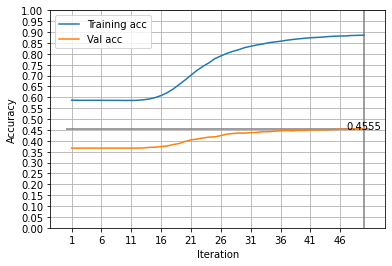

In [0]:
# source: p142 of the textbook (chapter 4)
# SGDClassifier now has an early stopping option built in but it doesn't work how I want so use a manual implementation:
from sklearn.linear_model import SGDClassifier

linear_svm2 = SGDClassifier(max_iter=1, warm_start=True, learning_rate='constant', eta0=0.0008)

train_accs, val_accs = [], []
max_accuracy = 0
best_epoch = None
best_model = None

num_iters = 50
for epoch in range(num_iters):
  linear_svm2.fit(X_train, y_train)
  train_acc, val_acc = accuracy_score(y_train, linear_svm2.predict(X_train)), accuracy_score(y_val, linear_svm2.predict(X_val))
  train_accs.append(train_acc)
  val_accs.append(val_acc)

plt.plot(np.arange(1, num_iters+1), train_accs, label='Training acc');
plt.plot(np.arange(1, num_iters+1), val_accs, label='Val acc');

plt.xlabel('Iteration'); plt.ylabel('Accuracy');
plt.ylim(0, 1.0);
plt.xticks(np.arange(1, num_iters+1, 5)); plt.yticks(np.arange(0, 1.05, 0.05));
plt.grid();
plt.legend();
max_acc, max_acc_iter = np.round(np.max(val_accs), 4), np.argmax(val_accs)+1
plt.vlines(x=max_acc_iter, ymin=0, ymax=1, color='gray', label='Max val acc');
plt.hlines(y=max_acc, xmin=0, xmax=num_iters+1, color='gray', label=None);
plt.annotate(max_acc, (max_acc_iter, max_acc), textcoords="offset points", xytext=(0,0), ha='center')

print('Max accuracy', max_acc, 'at epoch', max_acc_iter, "\n")

Use grid search with the linear SVM to see if the model paramaters (and pre-processing parameters) can be tweaked to improve the model.

Validation data is 1460 instances or ~17% of the total data set. Hence use 6 folds in cross validation so that 6th fold is essentially the validation set ('tweets_normalised_shuffled' is a concatenation of the shuffled training tweets and shuffled validation tweets)

Result: accuracy on the first 5 folds (almost the same as the training set) varies from ~70-85% but the accuracy on the 6th fold (almost the entire validation set) varies from 43-48%. **There must be a data mistmatch.**

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

linearsvm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])

linearsvm_grid = [{
    'tfidf__ngram_range':[(1,1), (1,2)],
    'tfidf__max_features':[500, 1000, 3500, 7000],
    'svc__C':[0.01, 0.1, 1, 10]
}]

grid_search = GridSearchCV(linearsvm_pipeline, linearsvm_grid, cv=6, scoring='accuracy')
grid_search.fit(tweets_normalised_shuffled, y)
print("Best model based on CV scores:", grid_search.best_params_, "\n")

results = grid_search.cv_results_

all_scores = []
for i in range(0, 6):
  score_str = 'split' + str(i) + '_test_score'
  all_scores.append(np.round(results[score_str], 2))

models_df = pd.DataFrame(results["params"])
scores_df = pd.DataFrame(np.c_[np.array(all_scores).transpose(), np.round(results["mean_test_score"], 2)],
                         columns=['1', '2', '3', '4', '5', '6', 'Avg'])
pd.concat([models_df, scores_df], axis=1)

Best model based on CV scores: {'svc__C': 0.1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)} 



,svc__C,tfidf__max_features,tfidf__ngram_range,1,2,3,4,5,6,Avg
0,0.01,500,"(1, 1)",0.740,0.751,0.743,0.721,0.708,0.470,0.689
1,0.01,500,"(1, 2)",0.736,0.737,0.731,0.719,0.700,0.473,0.683
2,0.01,1000,"(1, 1)",0.755,0.762,0.766,0.737,0.712,0.471,0.701
3,0.01,1000,"(1, 2)",0.753,0.760,0.767,0.738,0.719,0.469,0.701
4,0.01,3500,"(1, 1)",0.720,0.720,0.711,0.683,0.671,0.466,0.662
5,0.01,3500,"(1, 2)",0.723,0.718,0.712,0.684,0.676,0.468,0.664
6,0.01,7000,"(1, 1)",0.696,0.691,0.683,0.656,0.647,0.463,0.639
7,0.01,7000,"(1, 2)",0.704,0.710,0.692,0.665,0.650,0.461,0.647
8,0.10,500,"(1, 1)",0.763,0.780,0.769,0.743,0.717,0.471,0.707
9,0.10,500,"(1, 2)",0.755,0.762,0.756,0.737,0.709,0.472,0.699


Kaggle returns a score of 60% for the linear svm from above on the test data. The model is trained on the full data (training + validation) so is better than the model trained on the training data only.

In [0]:
def create_submission_file(model, X, y, X_test):
  model.fit(X, y)
  y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), model.predict(X_test)]
  y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
  y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)
  return accuracy_score(y, model.predict(X))

# create_submission_file(models['Linear SVM'], X, y, X_test)
create_submission_file(grid_search.best_estimator_, tweets_normalised_shuffled, y, tweets_test_normalised)

0.8673755550362234

Perform error analysis on the validation set using a selection of the candidate models to see what is going wrong with the predictions on the validation set. Per output from the below code cell:

- All models have higher accuracy/recall on fear and joy than anger and sadness and low accuracy/recall (30-40%) on sadness
- The error patterns are similar. A voting classifier may not be beneficial.
- The fear class has low precision, i.e. many non-fear tweets are mistakenly classified as fear (over 40% of anger and sadness tweets in most models).
- **The decision boundary estimated from the training data separates the classes almost perfectly in the training data but poorly in the validation set. The features deemed significant in predicting the emotions have not generalised well to the validation set (i.e. the model has overfit to features that define fear in the training set but are related to other emotions in the validation set).**

In [0]:
from sklearn.metrics import confusion_matrix

for model_name in ['Naive Bayes', 'Logistic Reg', 'Linear SVM', 'Random Forest']:
  model = models[model_name]
  y_val_predict = model.predict(X_val)
  cmtrx = confusion_matrix(y_val, y_val_predict)

  cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
  df = pd.DataFrame(np.round(cmtrx,2), columns=[[model_name] * 4, ["Predicted"] * 4, emotions], 
                       index=[["Actual"] * 4, emotions])
  display(df)
  print("\n")

Naive Bayes                    
                 Predicted                    
                     anger  fear   joy sadness
Actual anger          0.38  0.42  0.06    0.13
       fear           0.18  0.64  0.05    0.13
       joy            0.10  0.34  0.47    0.09
       sadness        0.20  0.47  0.07    0.26

Logistic Reg                    
                  Predicted                    
                      anger  fear   joy sadness
Actual anger           0.33  0.52  0.04    0.11
       fear            0.14  0.73  0.03    0.10
       joy             0.04  0.49  0.42    0.04
       sadness         0.14  0.58  0.04    0.24

Linear SVM                    
                Predicted                    
                    anger  fear   joy sadness
Actual anger         0.26  0.62  0.03    0.08
       fear          0.11  0.79  0.03    0.07
       joy           0.04  0.53  0.40    0.03
       sadness       0.12  0.65  0.04    0.20

Random Forest                    
                   Predicted                    
                       anger  fear   joy sadness
Actual anger            0.24  0.64  0.02    0.11
       fear             0.10  0.78  0.02    0.10
       joy              0.02  0.57  0.36    0.04
       sadness          0.10  0.63  0.03    0.25

Most important features are determined from the Logistic Regression to see if the model is giving significane to noise rather than true signals. The 10 most informative features for each emotion are displayed. The results make sense. However, some of the top words for fear such as 'awful' 'terrible' 'horrible' could easily be associated with anger or sadness.

In [0]:
# This idea came from:
# https://towardsdatascience.com/how-i-improved-my-text-classification-model-with-feature-engineering-98fbe6c13ef3

feature_names = np.array(tfidf_train.get_feature_names()).reshape(-1,1)

# make sure the model is the original one
lr_clf = LogisticRegression(multi_class='ovr', max_iter=500)
lr_clf.fit(X_train, y_train)
weights = np.round(lr_clf.coef_.transpose(), 3)

feature_importances = pd.DataFrame(weights, columns=emotions)
feature_importances.insert(0, 'Feature', feature_names)

for emotion in emotions:
  display(feature_importances.nlargest(10, emotion)[['Feature', emotion]])
  print("\n")

,Feature,anger
2132,offend,6.193
95,angry,5.804
89,anger,5.786
2455,rage,5.619
267,bitter,5.587
2556,revenge,5.453
1119,fume,5.076
2185,outrage,4.816
2930,sting,4.705
2826,snap,4.544


,Feature,fear
993,fear,5.211
2025,nervous,5.182
185,awful,5.173
2062,nightmare,5.088
2727,shake,5.020
356,bully,4.945
3050,terrible,4.901
3057,terrorism,4.873
1450,horrible,4.814
1454,horror,4.753


,Feature,joy
1421,hilarious,6.018
2515,rejoice,5.938
2811,smile,5.809
2166,optimism,5.801
455,cheer,5.774
1344,happy,5.135
1669,laughter,5.126
1194,glee,5.082
1744,lively,4.782
2315,playful,4.417


,Feature,sadness
287,blue,6.317
707,depression,5.925
2833,sober,5.883
704,depress,5.717
2616,sadness,5.644
3261,unhappy,5.500
2611,sad,5.412
657,dark,5.379
2784,sink,5.247
2712,serious,5.111


Look more closely at some of the errors. I include results from NLTK sentiment analyzer for comparison (final 4 columns in the data frame).

The data is shuffled so there will be different results everytime. In the following cell I analyse the results for some selected tweets. In general, my classifier is very uncertain based on the class probabilities.

In [0]:
# The 'neg', 'neu', 'pos', 'compound' columns are from NLTK SentimentIntensityAnalyzer

# These tweets are very ambiguous! The classifier is rightly confused (although NLTK is very confident about the first one)
#       anger	fear	joy	  sad   Actual	Predict neg	   neu	  pos	   compound  tweet
# 188	  0.09	0.6	  0.14	0.17	joy	    fear	  0.193  0.247  0.560  0.8720    one great horrible moment professor see wonderful student leave university true passion '
# 184	  0.07	0.81	0.05	0.06	joy	    fear	  0.462  0.220  0.319	 -0.3818   thanks someone suffer anxiety migraine always fear give hope	

# Not sure which word/s my classifier found 'fearful' in this tweet? NLTK rightly says it is positive sentiment.
#       anger	fear	joy	  sad   Actual	Predict neg	   neu	  pos	   compound  tweet
# 234	  0.13	0.33	0.3	  0.24	joy	    fear	  0.000  0.349  0.651	 0.6808    work help make world good	

# There are no emotion words in this tweet so not sure what the classifier is seeing?
#       anger	fear	joy	  sad   Actual	Predict neg	   neu	  pos	   compound  tweet
# 287	  0.13	0.66	0.09	0.12	joy	    fear	  0.000  1.000  0.000	 0.0000    someone need start listen idea	

# Is the following tweet actually joyful? I think my classifier has it more right than the official label here
#       anger	fear	joy	  sad   Actual	Predict neg	   neu	  pos	   compound  tweet
# 471	  0.12	0.71	0.08	0.08	joy	    fear	  0.404  0.596  0.000	 -0.2584   never excited start semester


In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
logreg_clf = LogisticRegression(multi_class='ovr', max_iter=500)
logreg_clf.fit(X_train, y_train)
y_val_predict = logreg_clf.predict(X_val)

num_tweets = 1000
decision_scores = np.round(logreg_clf.predict_proba(X_val)[:num_tweets], 2)
actual_emotions = [emotions[int(emotion_num)] for emotion_num in y_val[:num_tweets]]
predicted_emotions = [emotions[int(emotion_num)] for emotion_num in y_val_predict[:num_tweets]]
tweets = tweets_val_normalised_shuffled[:num_tweets]

polarity_scores = []
for tweet in tweets:
  polarity_score = sid.polarity_scores(tweet)
  polarity_scores.append(polarity_score)

pred_df = pd.DataFrame(np.c_[decision_scores, actual_emotions, predicted_emotions, tweets], columns = emotions + ['Actual', 'Predicted', 'Tweet'])
final_df = pd.concat([pred_df, pd.DataFrame(polarity_scores)], axis=1)
final_df.loc[(final_df['Actual']=='joy') & (final_df['Predicted'] != 'joy'), :][:20]

,anger,fear,joy,sadness,Actual,Predicted,Tweet,neg,neu,pos,compound
1,0.32,0.22,0.18,0.28,joy,anger,whenever turn radio hear bob dylan knock heave...,0.210,0.484,0.306,0.2023
4,0.08,0.25,0.24,0.42,joy,sadness,sad tonight awhile back hope everyone attend g...,0.193,0.373,0.435,0.5994
15,0.18,0.48,0.26,0.08,joy,fear,movie watch list spider man homecoming war pla...,0.239,0.613,0.147,-0.3612
26,0.47,0.22,0.14,0.16,joy,anger,get free machine,0.000,0.377,0.623,0.5106
32,0.19,0.31,0.17,0.33,joy,sadness,edit photo,0.000,1.000,0.000,0.0000
56,0.08,0.46,0.33,0.13,joy,fear,literally work almost everyday wait start bles...,0.000,0.741,0.259,0.4215
67,0.71,0.08,0.17,0.04,joy,anger,make angry laugh tweet,0.371,0.225,0.404,0.0772
70,0.18,0.2,0.08,0.54,joy,sadness,sad ultimately apparently support completely m...,0.287,0.463,0.250,-0.1027
77,0.28,0.17,0.16,0.38,joy,sadness,come damn boy joke stay great actual job thumb...,0.169,0.438,0.394,0.5574
84,0.13,0.26,0.24,0.36,joy,sadness,bedtime full listen reed album full album unde...,0.000,1.000,0.000,0.0000


In [0]:
# Heirarchal classification where I use NLTK to determine if a tweet is positive (joy) or not and then apply my model to classify
# the remaining negative tweets into fear, sadness and anger might work. Per below, NLTK can determine joyful tweets in the validation
# set with 72% accuracy. Unfortunately I don't have time to fully explore this idea.

joy_labels = [1 if emotions[int(emotion_num)]=='joy' else 0 for emotion_num in y_val]

nltk_preds = []
for tweet in tweets_val_normalised_shuffled:
  if sid.polarity_scores(tweet)['compound'] > 0:
    nltk_preds.append(1)
  else:
    nltk_preds.append(0)

accuracy_score(nltk_preds, joy_labels)

0.7493150684931507

## Feature selection:

The models are unlikely to be overfitting due to too much flexibility as some of them are reasonably simple models and they have been fit with the conservative default settings (e.g. by default, the linear svc sets C=1 and logistic regression applies l2 regularisation).

Below I try various feature selection methods to no avail.

*1. Select 1000 best features using chi-sq feature selection:*

Result: training accuracy decreases but validation accuracy remains similar. KNN is much improved though.

In [0]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

from sklearn.feature_selection import SelectKBest, chi2

tfidf_train_2 = TfidfVectorizer(ngram_range=(1, 2))
X_train_2 = tfidf_train_2.fit_transform(tweets_train_normalised_shuffled)
X_val_2 = tfidf_train_2.transform(tweets_val_normalised_shuffled)

chi2_selector = SelectKBest(chi2, k=1000)
X_train_2 = chi2_selector.fit_transform(X_train_2, y_train)
X_val_2 = chi2_selector.transform(X_val_2)
models = reset_models_to_original()
run_models(models, X_train_2, y_train, X_val_2, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Naive Bayes,KNN,Logistic Reg,Softmax,Linear SVM,Non-Linear SVM,Random Forest,Grad. Boosting
Training data,0.7539,0.8394,0.8142,0.8363,0.9001,0.8839,0.9474,0.8391
Validation data,0.4418,0.4342,0.4473,0.4507,0.4562,0.4397,0.4445,0.4233


In [0]:
# 57% on the public test set (worse than the initial linear SVM)
X = tfidf_train_2.fit_transform(tweets_normalised_shuffled)
X_test = tfidf_train_2.transform(tweets_test_normalised)
create_submission_file(models['Linear SVM'], X, y, X_test)

NameError: ignored

*2. Use a type of dimensionality reduction appropriate for a sparse matrix:*

Result: this method is too slow to run other than on logistic regression and linear SVM. It allows the models to achieve the same validation error at ~10% lower training error. No improvement to validation error though.

In [0]:
from sklearn.decomposition import TruncatedSVD

tfidf_train_3 = TfidfVectorizer(ngram_range=(1, 1))
X_train_3 = tfidf_train_3.fit_transform(tweets_train_normalised_shuffled)
X_val_3 = tfidf_train_3.transform(tweets_val_normalised_shuffled)

tsvd = TruncatedSVD(n_components=500)
X_train_3 = tsvd.fit_transform(X_train_3)
X_val_3 = tsvd.transform(X_val_3)
models = {"Logistic Reg" : LogisticRegression(multi_class='ovr', max_iter=500), "Linear SVM" : LinearSVC(C=0.1)}
run_models(models, X_train_3, y_train, X_val_3, y_val)

,Logistic Reg,Linear SVM
Training data,0.7849,0.7868
Validation data,0.4199,0.4226


*3. Use recursive feature elimination to fit the model with only the most important features from the logistic regression*

Result: no significant difference to other methods

In [0]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=models['Logistic Reg'], n_features_to_select=1000, step=100)
rfe.fit(X_train, y_train)
accuracy_score(y_val, rfe.predict(X_val))

0.4232876712328767

## Use grid-search to find a better model:

Finally, I try a grid search across multiple models:

In [0]:
# linear SVM - already done this
grid_search.best_estimator_.fit(tweets_train_normalised_shuffled, y_train)
y_pred = grid_search.best_estimator_.predict(tweets_val_normalised_shuffled)
accuracy_score(y_val, y_pred)
print("LINEAR SVM:")
print("Best model based on CV scores:", grid_search.best_params_)
print("Validation Accuracy:", accuracy_score(y_val, y_pred), "\n")

LINEAR SVM:
Best model based on CV scores: {'lr__C': 1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Validation Accuracy: 0.4541095890410959 



In [0]:
# # linear SVM (from earlier))
# grid_search.best_estimator_.fit(tweets_train_normalised_shuffled, y_train)
# y_pred = grid_search.best_estimator_.predict(tweets_val_normalised_shuffled)
# accuracy_score(y_val, y_pred)
# print("LINEAR SVM:")
# print("Best model based on CV scores:", grid_search.best_params_)
# print("Validation Accuracy:", accuracy_score(y_val, y_pred), "\n")

# logistic regression
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter=500))])
grid = [{'tfidf__ngram_range':[(1,1), (1,2)], 'tfidf__max_features':[500, 1000, 3500, 7000], 'lr__C':[0.1, 1, 10]}]
grid_search = GridSearchCV(pipeline, grid, cv=6, scoring='accuracy')
grid_search.fit(tweets_normalised_shuffled, y)
grid_search.best_estimator_.fit(tweets_train_normalised_shuffled, y_train)
y_val_pred = grid_search.best_estimator_.predict(tweets_val_normalised_shuffled)
print("LOGISTIC REGRESSION:")
print("Best model based on CV scores:", grid_search.best_params_)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred), "\n")

# random forest
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
grid = [{'tfidf__ngram_range':[(1,1), (1,2)], 'tfidf__max_features':[500, 1000, 3500, 7000],
         'rf__max_depth':[10, 25, 50, None], 'rf__n_estimators':[10, 100, 500], 'rf__max_samples':[0.1, 0.5, 1]}]
grid_search = GridSearchCV(pipeline, grid, cv=6, scoring='accuracy')
grid_search.fit(tweets_normalised_shuffled, y)
grid_search.best_estimator_.fit(tweets_train_normalised_shuffled, y_train)
y_val_pred = grid_search.best_estimator_.predict(tweets_val_normalised_shuffled)
print("RANDOM FOREST:")
print("Best model based on CV scores:", grid_search.best_params_)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred), "\n")

# non-linear SVM
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('svc', SVC())])
grid = [{'tfidf__ngram_range':[(1,1), (1,2)], 'tfidf__max_features':[500, 1000, 3500, 7000], 'svc__C':[0.1, 1, 10]}]
grid_search = GridSearchCV(pipeline, grid, cv=6, scoring='accuracy')
grid_search.fit(tweets_normalised_shuffled, y)
grid_search.best_estimator_.fit(tweets_train_normalised_shuffled, y_train)
y_val_pred = grid_search.best_estimator_.predict(tweets_val_normalised_shuffled)
print("NON-LINEAR SVM:")
print("Best model based on CV scores:", grid_search.best_params_)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred), "\n")

LOGISTIC REGRESSION:
Best model based on CV scores: {'lr__C': 1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Validation Accuracy: 0.4541095890410959 



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

RANDOM FOREST:
Best model based on CV scores: {'rf__max_depth': None, 'rf__max_samples': 0.5, 'rf__n_estimators': 500, 'rf__oob_score': False, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Validation Accuracy: 0.4541095890410959 

NON-LINEAR SVM:
Best model based on CV scores: {'svc__C': 10, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Validation Accuracy: 0.4541095890410959 



## Conclusion for conventional machine learning:

The poor performance is not due to the algorithms/models as they easily overfit the training data and I have explored multiple configurations for multiple models. The issue is the data:

- Data mismatch: my first grid search with 6 folds (the 6th fold being the validation data) showed that the validation data could be from a different distribution than the training data as the accuracy on the validation fold was much lower than folds 1-5.

- Noisy data: various feature extraction methods made no difference so I think ~45% on the validation set and ~60% on the public test set is the best I can do without further pre-processing. My error analysis confirms the noisyness (e.g. for tweets that have multiple emotion words like 'anger' and 'happy' in the same tweet, something needs to be done as the classifier is going to be confused). Some pre-processed tweets have no emotion words in them at all so may also confuse the classifier. Other possible issues: more than 2 letters repeated (e.g. haaaappppyyy instead of happy), general mispelling and slang. I've done some research on this and also tried a few things not shown but nothing helped. Unsure how to proceed.

# Train deep learning models:

In [0]:
# function to plot results for different deep learning models

def plot_model_results(history, epochs=100, x_step=5):  
  train_accuracy = history.history['accuracy']
  acc_for_max = train_accuracy

  if 'val_accuracy' in history.history.keys():
    val_accuracy = history.history['val_accuracy']
    plt.plot(np.arange(1, epochs+1), val_accuracy, label='Val acc');
    acc_for_max = val_accuracy

  plt.plot(np.arange(1, epochs+1), train_accuracy, label='Training acc');
  plt.xlabel('Epoch'); plt.ylabel('Accuracy');
  plt.ylim(0, 1.0);
  plt.xticks(np.arange(1, epochs+1, x_step)); plt.yticks(np.arange(0, 1.05, 0.05));
  plt.grid();
  plt.legend();
  max_acc, max_acc_epoch = np.round(np.max(acc_for_max), 4), np.argmax(acc_for_max)+1
  plt.vlines(x=max_acc_epoch, ymin=0, ymax=1, color='gray', label='Max val acc');
  plt.hlines(y=max_acc, xmin=0, xmax=epochs+1, color='gray', label=None);
  plt.annotate(max_acc, (max_acc_epoch, max_acc), textcoords="offset points", xytext=(0,0), ha='center')

  print('Max accuracy', max_acc, 'at epoch', max_acc_epoch, "\n")

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import InputLayer, Dense, Dropout, Flatten, Activation, Embedding, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
from keras.layers import BatchNormalization, Concatenate, Input, MaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from functools import partial

Using TensorFlow backend.


### Build a simple dense network as a baseline to compare against:

In [0]:
# will re-use this variable in multiple models
DenseLayer = partial(Dense, activation='relu', kernel_initializer='he_normal')

def new_dense_model():
  neurons_per_layer = 2500

  model_dense = Sequential([
      InputLayer(input_shape=(1000,)),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      Dropout(0.2),
      Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
  ])   
  return model_dense

In [0]:
model_dense_train = new_dense_model()
model_dense_train.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2500)              2502500   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2500)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2500)              6252500   
_________________________________________________________________
dropout_11 (Dropout)         (None, 2500)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2500)              6252500   
_________________________________________________________________
dropout_12 (Dropout)         (None, 2500)             

Max validation accuracy of 45.41% is similar to the conventional models. Max accuracy is reached at epoch 40 but is essentially reached at epoch 21 when training accuracy is only 70%. Anything after this I consider overfitting.

Max accuracy 0.4329 at epoch 22 



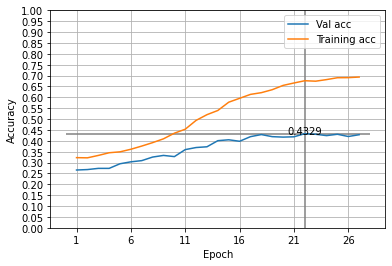

In [0]:
model_dense_train.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model_dense_train.fit(X_train_2, y_train, epochs=100, validation_data=(X_val_2, y_val), verbose=False, 
                                callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

In [0]:
# # X_val_special = tfidf_all.transform(val_set[:, 0])

# # compare SVM and dl on the special validation data
# pred_dl_val = np.argmax(model_dense_train.predict(X_val), axis=1)

# models['Linear SVM'].fit(X_train, y_train)
# pred_conv_val = models['Linear SVM'].predict(X_val)

# print("VAL SET")
# print("SVM acc:", accuracy_score(y_val, pred_conv_val))
# print("DL acc:", accuracy_score(y_val.astype(np.int64), pred_dl_val))
# print("SVM vs. DL:", accuracy_score(pred_dl_val, pred_conv_val.astype(np.int64)))
# print("\n")

# # dl on the validation data
# from sklearn.metrics import confusion_matrix

# cmtrx = confusion_matrix(y_val.astype(np.int64), pred_dl_val)
# cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
# print("DL Val")
# print(np.round(cmtrx, 2))
# print("\n")

# # SVM on the validation data
# cmtrx = confusion_matrix(y_val, pred_conv_val)
# cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
# print("SVM Val")
# print(np.round(cmtrx, 2))
# print("\n")

Kaggle scores the above model at 59% on the public test set (below the 60.5% achieved with the linear svm):

Max accuracy 0.855 at epoch 95 



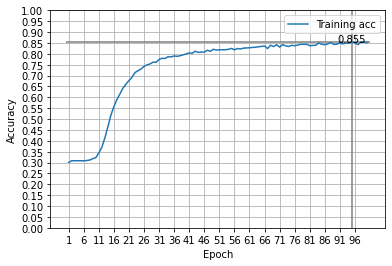

In [0]:
# need to create a new model to fit to X as the previous model is already fit to X_train
model_dense_all = new_dense_model()
model_dense_all.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model_dense_all.fit(X, y, epochs=100, verbose=False,
                              callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='loss')])
plot_model_results(history, epochs=len(history.history['accuracy']))
y_pred = np.argmax(model_dense_all.predict(X_test), axis=1)

In [0]:
y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), y_pred]
y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)

In [0]:
# X_val_special = tfidf_all.transform(val_set[:, 0])

# # compare SVM and dl on the special validation data
# pred_dl_val = np.argmax(model_dense_all.predict(X_val_special), axis=1)

# models['Linear SVM'].fit(X, y)
# pred_conv_val = models['Linear SVM'].predict(X_val_special)

# print("VAL SET")
# print("SVM acc:", accuracy_score(y_val, pred_conv_val))
# print("DL acc:", accuracy_score(y_val.astype(np.int64), pred_dl_val))
# print("SVM vs. DL:", accuracy_score(pred_dl_val, pred_conv_val.astype(np.int64)))
# print("\n")

# # dl on the validation data
# from sklearn.metrics import confusion_matrix

# cmtrx = confusion_matrix(y_val.astype(np.int64), pred_dl_val)
# cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
# print("DL Val")
# print(np.round(cmtrx, 2))
# print("\n")

# # SVM on the validation data
# cmtrx = confusion_matrix(y_val, pred_conv_val)
# cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
# print("SVM Val")
# print(np.round(cmtrx, 2))
# print("\n")

# # compare models on the test data
# print("TEST SET")
# models['Linear SVM'].fit(X, y)
# pred_conv = models['Linear SVM'].predict(X_test)
# print("SVM vs. DL", accuracy_score(y_pred, pred_conv.astype(np.int64)))
# print(y_pred[0:10])
# print(pred_conv[0:10].astype(np.int64))

### Using an embedding layer instead of BoW:

In [0]:
model_embed = Sequential([
    Embedding(len(vocabulary), 25, mask_zero=True, input_length=52),
    GlobalAveragePooling1D(),
    Dropout(0.2),

    DenseLayer(25),
    Dropout(0.2),

    DenseLayer(25),
    Dropout(0.2),
    
    DenseLayer(25),
    Dropout(0.2),

    Dense(4, activation='softmax')
])

model_embed.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 52, 25)            349450    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 25)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_17 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)               

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Max accuracy 0.4253 at epoch 8 



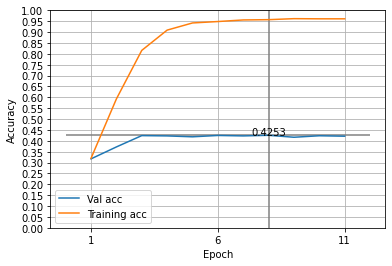

In [0]:
# note, the non pre-processed tweets are being used here
model_embed.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_embed.fit(tweets_train, labels_train, epochs=100, validation_data=(tweets_val, labels_val), verbose=False,
                          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

### Use pre-trained embeddings:

In [0]:
import tensorflow_hub as hub
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [0]:
def new_pretrained_model():
  model_pretrain = keras.Sequential([
      hub_layer,
      # tf.keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(4, activation='softmax')
  ])
  return model_pretrain

model_pretrain = new_pretrained_model()
model_pretrain.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5

In [0]:
# convert the tweets to string format WITHOUT pre-processing. hub_layer requires this input format.

def tweets_to_strings(tweets):
  tweetstrings = []
  for tweet in tweets:
    tweet_string = ""
    for vocab_idx in tweet:
      word = emoji.demojize(idx_to_word[vocab_idx])
      if word == '<END>': break
      if word not in ['<START>', '<NULL>', '<user>']:
        for subword in word_tokenize(word): # word_tokenize splits off the hashtags
          tweet_string = tweet_string + subword + " "
  
    tweetstrings.append(tweet_string)

  return tweetstrings

tweetstrings_train, tweetstrings_val = tf.constant(tweets_to_strings(tweets_train)), tf.constant(tweets_to_strings(tweets_val))

Max accuracy 0.4493 at epoch 6 



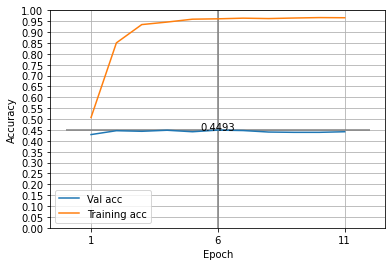

In [0]:
model_pretrain.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_pretrain.fit(tweetstrings_train, labels_train, epochs=100, validation_data=(tweetstrings_val, labels_val), verbose=False,
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

In [0]:
# now train the model using the tweets in string format WITH pre-processing:
tweetstrings_train, tweetstrings_val, tweetstrings_test = tf.constant(tweets_train_normalised_shuffled), tf.constant(tweets_val_normalised_shuffled), tf.constant(tweets_test_normalised)

model_pretrain = new_pretrained_model() # need a new model to reset weights
model_pretrain.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_pretrain.fit(tweetstrings_train, y_train, epochs=100, validation_data=(tweetstrings_val, y_val), verbose=False,
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

### Use a CNN:

In [0]:
model_cnn = Sequential([
    Embedding(len(vocabulary), 25, input_length=52),
    # GlobalAveragePooling1D(),
    Dropout(0.3),

    Conv1D(25, 2, padding='valid', activation='relu', strides=1),
    MaxPool1D(),
    Conv1D(25, 2, padding='valid', activation='relu', strides=1),
    MaxPool1D(),

    Flatten(),

    DenseLayer(100),
    Dropout(0.3),
    DenseLayer(100),
    Dropout(0.3),
    DenseLayer(100),
    Dropout(0.3),
    Dense(4, activation="softmax"),
])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52, 25)            349450    
_________________________________________________________________
dropout_2 (Dropout)          (None, 52, 25)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 51, 25)            1275      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 25)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 25)            1275      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 25)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Max accuracy 0.4315 at epoch 22 



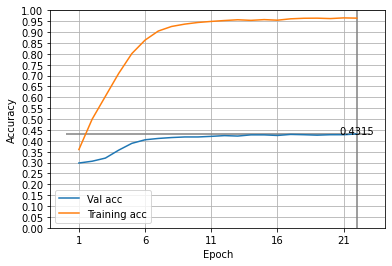

In [0]:
# note, the non pre-processed tweets are being used here
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_cnn.fit(tweets_train, labels_train, epochs=100, validation_data=(tweets_val, labels_val), verbose=False,
                        callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

### Use a multi-channel CNN:

- Architecture from http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

- Used https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/ to help a little with this code as couldn't figure out input layer myself

In [0]:
# The tweets were originally provided in tokenized format but I pre-processed them into strings. Below I re-tokenize them
# these pre-processed tweets. Using pre-processed and non pre-processed tweets didn't make much difference in the prior models though.

all_tweets = list(tweets_normalised_shuffled) + tweets_test_normalised

tokenizer = Tokenizer()
tweets_normalised_tokenized = tokenizer.fit_on_texts(tweets_normalised_shuffled)
encoded = tokenizer.texts_to_sequences(all_tweets)
padded = pad_sequences(encoded, maxlen=52, padding='post')
vocab_size = len(tokenizer.word_index) + 1

tweets_train_retokenized, tweets_val_retokenized, tweets_test_retokenized = padded[:7098], padded[7098:8558], padded[8558:]

tweets_train_retokenized.shape, tweets_val_retokenized.shape, tweets_test_retokenized.shape

((7098, 52), (1460, 52), (4064, 52))

In [0]:
input_ = Input(shape=(52,))
embedding = Embedding(vocab_size, 20)(input_)
conv1 = Conv1D(50, 1, padding='valid', activation='relu', strides=1)(embedding)
pool1 = GlobalMaxPooling1D()(conv1)

conv2 = Conv1D(50, 2, padding='valid', activation='relu', strides=1)(embedding)
pool2 = GlobalMaxPooling1D()(conv2)

conv3 = Conv1D(50, 3, padding='valid', activation='relu', strides=1)(embedding)
pool3 = GlobalMaxPooling1D()(conv3)

concat = Concatenate()([pool1, pool2, pool3])
dense = Dense(3, activation="relu", kernel_initializer='he_normal')(concat)
output = Dense(4, activation="softmax")(dense)

model_cnn_ns = Model(inputs=[input_], outputs=[output])

model_cnn_ns.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 52, 20)       146940      input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 52, 50)       1050        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 51, 50)       2050        embedding_1[0][0]                
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Max accuracy 0.4233 at epoch 5 



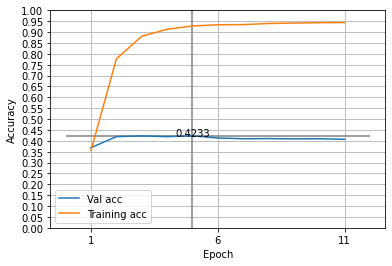

In [0]:
model_cnn_ns.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_cnn_ns.fit(tweets_train_retokenized, y_train, epochs=100, validation_data=(tweets_val_retokenized, y_val), verbose=False,
                           callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

In [0]:
y_pred = np.argmax(model_cnn_ns.predict(tweets_test_retokenized), axis=1)

In [0]:
y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), y_pred]
y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)

# More data:

In [0]:
# SOURCE: https://tlkh.github.io/text-emotion-classification/

# tweets_train_new_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset/training_new.csv")
# tweets_train_new = tweets_train_new_df['content']
# y_new = tweets_train_new_df['Emotion']

In [0]:
# def normalise_tweets_2(tweets, labels):
#   lemmatizer = WordNetLemmatizer()
#   stop_punct = stopwords.words('english') + list(string.punctuation)
  
#   normalised_tweets = []
#   new_labels = []

#   index = 0
#   for tweet in tweets:
#     tweet_words = []
#     tweet = tweet.lower()
#     for word in word_tokenize(tweet):
#       if word not in ['<START>', '<END>', '<NULL>', '<user>'] and word in emotion_words:
#         tweet_words += word_tokenize(emoji.demojize(word))

#     normalised_tweet = ""
#     for word, tag in pos_tag(tweet_words):
#       if word not in stop_punct and not word.isdigit():
#         if tag.startswith('NN'):
#             pos = 'n'
#         elif tag.startswith('VB'):
#             pos = 'v'
#         else:
#             pos = 'a'
#         normalised_tweet = normalised_tweet + lemmatizer.lemmatize(word, pos) + ' '
    
#     if len(normalised_tweet) > 0:
#       normalised_tweets.append(normalised_tweet)
#       new_labels.append(labels[index])
    
#     index += 1
#   return normalised_tweets, new_labels

In [0]:
# tweets_train_new_normalised, y_train_new = normalise_tweets_2(tweets_train_new, y_new)
# tweets_train_new_normalised

In [0]:
# tweets_train_all = tweets_train_normalised + tweets_train_new_normalised
# y_train_all = np.array(list(y_train) + list(y_train_new))

# len(tweets_train_new), len(y_new), len(tweets_train_new_normalised),len(y_train_new)

In [0]:
# # print(tweets_train_new[15])
# # word_tokenize(tweets_train_new[15])
# # normalise_tweets_2([tweets_train_new[15]])

# tfidf_vect_2 = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

# #len(tweets_train_new_normalised[:21000]), len(tweets_train_new_normalised[21000:])

# tfidf_vect_2.fit(tweets_train_new_normalised[:21000])
# X_train_new = tfidf_vect_2.transform(tweets_train_new_normalised[:21000])
# X_val_new = tfidf_vect_2.transform(tweets_train_new_normalised[21000:])
# y_train_new = y_new[:21000]
# y_val_new = y_new[21000:]

# # X = tfidf_vect_2.fit_transform(tweets_normalised)
# # y = np.concatenate([y_train, y_val])

# X_train_new.shape, y_train_new.shape, X_val_new.shape, y_val_new.shape#, X.shape, y.shape

((21000, 128696), (21000,), (5643, 128696), (5643,))

In [0]:
# tweets_train_all = tweets_train_normalised + tweets_train_new_normalised
# y_train_new = np.array(list(y_train) + list(tweets_train_new_df['Emotion']))

# tfidf_vect_new = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
# tfidf_vect_new.fit(tweets_train_all)
# X_train_new = tfidf_vect_new.transform(tweets_train_all)
# X_val_new = tfidf_vect_new.transform(tweets_val_normalised)

# X_train_new.shape, y_train_new.shape, X_val_new.shape, y_val.shape

# Other:

Heirarchal classification:

In [0]:
y_train_sentiment = []
for emotion_num in y_train:
  if emotion_num == '2':
    y_train_sentiment.append(1)
  else:
    y_train_sentiment.append(0)
y_train_sentiment = np.array(y_train_sentiment)

y_val_sentiment = []
for emotion_num in y_val:
  if emotion_num == '2':
    y_val_sentiment.append(1)
  else:
    y_val_sentiment.append(0)
y_val_sentiment = np.array(y_val_sentiment)

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf_p = LinearSVC()#fit_prior=False)
nb_clf_p.fit(X_train, y_train_sentiment)
print(accuracy_score(y_train_sentiment, nb_clf_p.predict(X_train)),
      accuracy_score(y_val_sentiment, nb_clf_p.predict(X_val)))

# split off negative tweets
y_train_predict_sentiment = nb_clf_p.predict(X_train)
y_val_predict_sentiment = nb_clf_p.predict(X_val)
#print(y_train_predict[0:10])

neg_tweets_train = tweets_train_normalised_shuffled[y_train_predict_sentiment==0]
neg_tweets_val = tweets_val_normalised_shuffled[y_val_predict_sentiment==0]

X_train_n = tfidf_train.fit_transform(neg_tweets_train)
X_val_n = tfidf_train.transform(neg_tweets_val)
y_train_n = y_train[y_train_predict_sentiment==0]
y_val_n = y_val[y_val_predict_sentiment==0]

X_train_n.shape, y_train_n.shape, X_val_n.shape, y_val_n.shape

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf_n = LinearSVC()#fit_prior=False)
nb_clf_n.fit(X_train_n, y_train_n)
print(accuracy_score(y_train_n, nb_clf_n.predict(X_train_n)), accuracy_score(y_val_n, nb_clf_n.predict(X_val_n)))

final_labels = []
y_val_predict_n = nb_clf_n.predict(X_val_n)

neg_counter = 0
for label in y_val_predict_sentiment:
  if label == 1:
    final_labels.append(2)
  else:
    final_labels.append(y_val_predict_n[neg_counter])
    neg_counter += 1

confusion_matrix(y_val_predict_sentiment, y_val_sentiment)
accuracy_score(final_labels, y_val)

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=1000, learning_rate=1
)
ada_clf.fit(X_train, y_train)
print(accuracy_score(y_train, ada_clf.predict(X_train)), accuracy_score(y_val, ada_clf.predict(X_val)))

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('nb', nb_clf), ('svm', linearsvm_clf), ('ada', ada_clf)], voting='hard'
)
voting_clf.fit(X_train, y_train)
accuracy_score(y_train, voting_clf.predict(X_train)), accuracy_score(y_val, voting_clf.predict(X_val))